# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

Using TensorFlow backend.


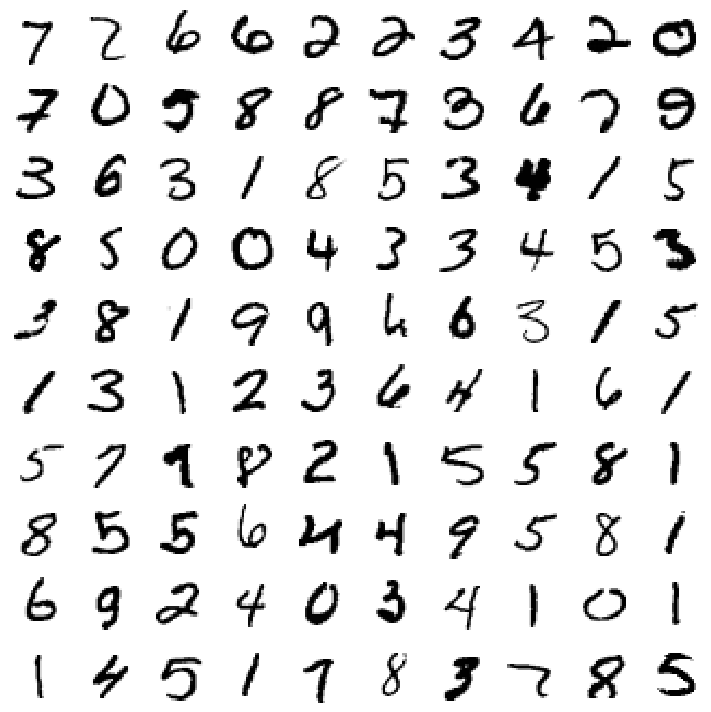

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train_mnist = (x_train_mnist / 255.0).astype(np.float32)
x_test_mnist = (x_test_mnist / 255.0).astype(np.float32)

# convert the data to channel-last
x_train_mnist = np.expand_dims(x_train_mnist, axis=-1)
x_test_mnist = np.expand_dims(x_test_mnist, axis=-1)

# convert the labels to one-hot encoded
y_train_mnist = to_categorical(y_train_mnist, num_classes=10)
y_test_mnist = to_categorical(y_test_mnist, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train_mnist[np.random.randint(0, x_train_mnist.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Compile and train the network (note that this could take a while).

In [3]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train_mnist, y_train_mnist,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test_mnist, y_test_mnist))

score1 = model.evaluate(x_test_mnist, y_test_mnist, verbose=0)

print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 4s 69us/step - loss: 0.2494 - accuracy: 0.9233 - val_loss: 0.0578 - val_accuracy: 0.9814
Epoch 2/12
60000/60000 [==============================] - 3s 45us/step - loss: 0.0876 - accuracy: 0.9736 - val_loss: 0.0407 - val_accuracy: 0.9873
Epoch 3/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.0670 - accuracy: 0.9798 - val_loss: 0.0366 - val_accuracy: 0.9884
Epoch 4/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.0552 - accuracy: 0.9837 - val_loss: 0.0343 - val_accuracy: 0.9881
Epoch 5/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.0471 - accuracy: 0.9853 - val_loss: 0.0344 - val_accuracy: 0.9880
Epoch 6/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.0405 - accuracy: 0.9873 - val_loss: 0.0305 - val_accuracy: 0.9906
Epoch 7/12
60000/60000 [==============================] - 3s 42us/st

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [4]:
score1 = model.evaluate(x_test_mnist, y_test_mnist, verbose=0)

print('Test loss:', score1[0])
print('Test accuracy:', score1[1])


Test loss: 0.028366533721568648
Test accuracy: 0.991100013256073


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


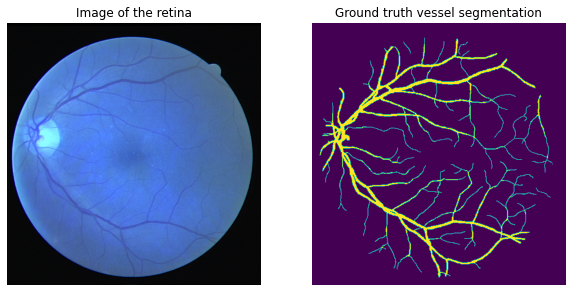

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

import sys
sys.path.append('code/')

from unet_utils import load_data

# location of the DRIVE dataset
data_folder = 'DataWeek4/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)



plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


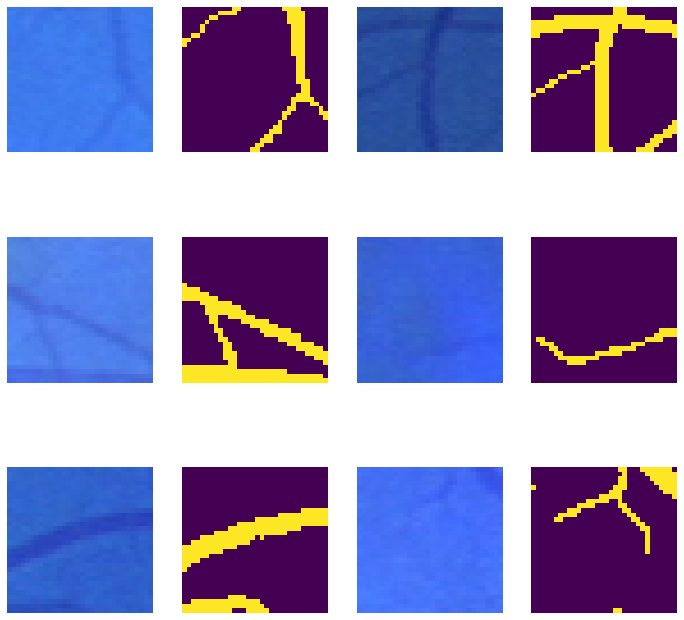

In [6]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [7]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)


Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [8]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)
X_val,y_val = np.expand_dims(val_images[0], axis=0), np.expand_dims(val_masks[0], axis=0)
print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)
model_bright = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)
model_b_spline = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)
# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])


(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/250
 - 7s - loss: 0.4728 - accuracy: 0.8726 - val_loss: 0.3789 - val_accuracy: 0.9211
Epoch 2/250
 - 2s - loss: 0.3164 - accuracy: 0.9494 - val_loss: 0.2816 - val_accuracy: 0.9211
Epoch 3/250
 - 2s - loss: 0.2205 - accuracy: 0.9592 - val_loss: 0.3041 - val_accuracy: 0.9211
Epoch 4/250
 - 2s - loss: 0.1652 - accuracy: 0.9611 - val_loss: 0.3296 - val_accuracy: 0.9211
Epoch 5/250
 - 2s - loss: 0.1515 - accuracy: 0.9603 - val_loss: 0.2659 - val_accuracy: 0.9221
Epoch 6/250
 - 2s - loss: 0.1593 - accuracy: 0.9600 - val_loss: 0.3586 - val_accuracy: 0.9215
Epoch 7/250
 - 2s - loss: 0.1261 - accuracy: 0.9623 - val_loss: 0.3006 - val_accuracy: 0.9215
Epoch 8/250
 - 2s - loss: 0.1212 - accuracy: 0.9621 - val_loss: 0.2431 - val_accuracy: 0.9286
Epoch 9/250
 - 2s - loss: 0.1163 - accuracy: 0.9635 - val_loss: 0.2456 - val_accuracy: 0.9328
Epoch 10/250
 - 2s - loss: 0.1405 - accuracy: 0.9586 - val_loss: 0.2505 - val_accuracy: 0.9277
Epoch 11/250
 - 2s - loss

### Visualizing the segmentation results

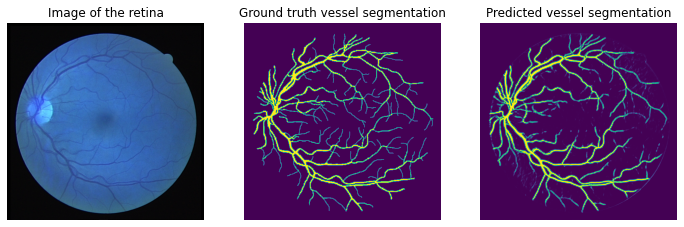

Test loss: 2.9811863899230957
Test accuracy: 0.4244552254676819


In [9]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# score of the baseline
score_base = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_base[0])
print('Test accuracy:', score_base[1])

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>


***Answer***

The parameters of a neural network are the weights that are learned during training. The number of parameters in a given layer is the count of features for a filter. Parameters are changed by the training algorithm that is used to train the model.
    
The general expression for the number of parameters of a convolutional layer is as follows:
***parameter*** = ((***shape of width of the filter*** * ***shape of height of the filter*** * ***number of filters in the previous layer***) + ***1***) * ***number of filters in the current layer*** 
    
When this formula is used on the simple network for the handwritten digit classification above. The parameters of the second convolutional layer is calculated by = ((3 * 3 * 32) + 1) * 64 = 18496
    
The general expression for the number of parameters of a fully connected layer is as follows:
parameter = (***previous layer neurons*** + ***1***) * ***current layer neurons***
    
When this formula is used on the simple network for the handwritten digit classification above. The parameters of the second dense layer is calculated by = (128 + 1) * 10 = 1290 
    
    
## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 





In [10]:
from keras.layers import GlobalAveragePooling2D

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(128,(12,12),activation='relu'))
model2.add(Dropout(0.25))

model2.add(Conv2D(10,(1,1),activation = 'softmax'))
model2.add(GlobalAveragePooling2D())

model2.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 1, 1, 128)         1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 1, 1, 10)         

In [11]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model2.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy']) 

model2.fit(x_train_mnist, y_train_mnist,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test_mnist, y_test_mnist))

score2 = model2.evaluate(x_test_mnist, y_test_mnist, verbose=0)

print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 4s 61us/step - loss: 0.1901 - accuracy: 0.9425 - val_loss: 0.0582 - val_accuracy: 0.9813
Epoch 2/12
60000/60000 [==============================] - 3s 55us/step - loss: 0.0594 - accuracy: 0.9821 - val_loss: 0.0387 - val_accuracy: 0.9865
Epoch 3/12
60000/60000 [==============================] - 3s 56us/step - loss: 0.0422 - accuracy: 0.9865 - val_loss: 0.0306 - val_accuracy: 0.9895
Epoch 4/12
60000/60000 [==============================] - 3s 54us/step - loss: 0.0309 - accuracy: 0.9897 - val_loss: 0.0359 - val_accuracy: 0.9886
Epoch 5/12
60000/60000 [==============================] - 3s 54us/step - loss: 0.0272 - accuracy: 0.9911 - val_loss: 0.0339 - val_accuracy: 0.9894
Epoch 6/12
60000/60000 [==============================] - 3s 56us/step - loss: 0.0232 - accuracy: 0.9924 - val_loss: 0.0299 - val_accuracy: 0.9914
Epoch 7/12
60000/60000 [==============================] - 3s 56us/st

In [12]:
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])


Test loss: 0.03311304301484915
Test accuracy: 0.9912999868392944


## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

#### Answer:
Skip connections skip some layers in the neural network and feeds the output of one layer as the input to the next layer. Usually, some information is captured in the initial layers and is required for reconstruction during the up-sampling done using the fully connected network layer. If we would not have used the skip architecture that information would have been lost or it would have turned too abstract for it to be used further. The original image would not be correctly reconstructed, because of a lack of information in the final layer, while increasing the displayed information. Moreover, skip connections help to pass through information faster in deep neural networks. Without skip connections, the reconstruction of the original image will be very slow. Therefore, it is not possible for very complex networks to omit the skip connections. For other networks it might work without skip connections. However, there will be a lack of information in the final layer and as a result the original image will not be correctly reconstructed.


## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

#### Answer:
With data augmentation, transformations to the already available training images are made, such that there can be trained with more data. It thus is the regeneration of more images from already-available ones, thereby creating a more diverse dataset. The modifications to the learning algorithm intend to reduce the generalization error but not the training error. The model will be trained on a less specific dataset, resulting in less overfitting. 

Data augmentation on the test samples does not change the training of the model itself, but it can be applied to see how the trained model behaves on such images. It is namely possible that the model behaves well for one test sample, but not for those with for example a slightly different intensity. You could perform cross validation to subsequently split your augmented and original data in test and training, such that the performance can be determined for different divisions. 

_____

Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above.

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

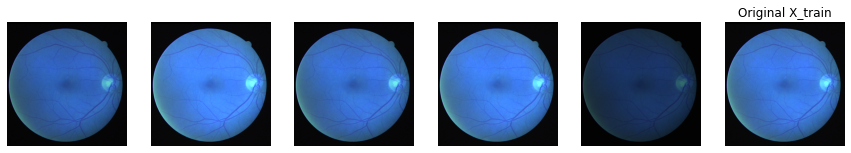

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import numpy as np
from unet_utils import preprocessing


# ImageDataGenerator for brightness 
# brightness_range is the range for picking a brightness shift value from
datagen_augm = ImageDataGenerator(brightness_range=[0.4,1.5])  # choose realistic values

# iterator
aug_iter = datagen_augm.flow(X_train, batch_size=1)

# generate batch of images
nr_batches = 5
X_train_augm = np.zeros((nr_batches+1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
y_train_augm = np.zeros((nr_batches+1, X_train.shape[1], X_train.shape[2], 1))
                     
fig, ax = plt.subplots(nrows=1, ncols=nr_batches+1, figsize=(15,15))
for i in range(nr_batches):

    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
    X_train_augm[i] = image
    y_train_augm[i] = y_train
    
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

# remove first axis
X_train_sq = np.squeeze(X_train)

# put original X_train in matrix
X_train_augm[i+1] = X_train_sq
y_train_augm[i+1] = y_train

# plot original image
ax[i+1].imshow(X_train_sq)
ax[i+1].set_title('Original X_train')
ax[i+1].axis('off')

plt.show()

In [14]:
model_brightness = model_bright
model_brightness.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the (already existing) model with the brightness augmented trainingset, and save the training history
history_brightness = model_brightness.fit(datagenerator(X_train_augm, y_train_augm, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])




Epoch 1/250
 - 5s - loss: 0.4827 - accuracy: 0.8372 - val_loss: 0.3894 - val_accuracy: 0.9211
Epoch 2/250
 - 2s - loss: 0.2774 - accuracy: 0.9532 - val_loss: 0.3860 - val_accuracy: 0.9211
Epoch 3/250
 - 2s - loss: 0.2141 - accuracy: 0.9582 - val_loss: 0.2822 - val_accuracy: 0.9211
Epoch 4/250
 - 2s - loss: 0.1523 - accuracy: 0.9629 - val_loss: 0.2945 - val_accuracy: 0.9211
Epoch 5/250
 - 2s - loss: 0.1373 - accuracy: 0.9615 - val_loss: 0.2845 - val_accuracy: 0.9211
Epoch 6/250
 - 2s - loss: 0.1179 - accuracy: 0.9655 - val_loss: 0.3496 - val_accuracy: 0.9211
Epoch 7/250
 - 2s - loss: 0.1260 - accuracy: 0.9599 - val_loss: 0.3935 - val_accuracy: 0.9211
Epoch 8/250
 - 2s - loss: 0.1051 - accuracy: 0.9661 - val_loss: 0.4254 - val_accuracy: 0.9211
Epoch 9/250
 - 2s - loss: 0.1038 - accuracy: 0.9642 - val_loss: 0.4183 - val_accuracy: 0.9211
Epoch 10/250
 - 2s - loss: 0.0957 - accuracy: 0.9665 - val_loss: 0.3749 - val_accuracy: 0.9211
Epoch 11/250
 - 2s - loss: 0.0957 - accuracy: 0.9661 - val_

In [15]:
# score brightness augmented model
score_brightness = model_brightness.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_brightness[0])
print('Test accuracy:', score_brightness[1])

Test loss: 1.9443618059158325
Test accuracy: 0.3421109616756439


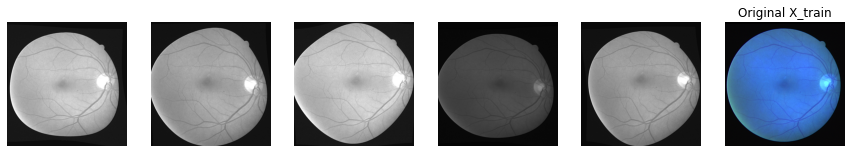

In [16]:
import gryds
from skimage import io, color

# Change image from color to gray (from 3D to 2D) to make it possible to use gryds
X_train_sq_gr = color.rgb2gray(X_train_sq)

# define number of different augmented (brightness + b-spline) images:
nr_batches = 5
X_train_bspl_augm = X_train_augm 

# first apply b-spline (a random B-spline grid is chosen for every image), then brightness augmentation
fig, ax = plt.subplots(nrows=1, ncols=nr_batches+1, figsize=(15,15))
for i in range(nr_batches):
    # Define a random 3x3 B-spline grid for a 2D image:
    random_grid = np.random.rand(2, 3, 3)
    random_grid -= 0.5
    random_grid /= 10
    
    # Define a B-spline transformation object
    bspline = gryds.BSplineTransformation(random_grid)

    # Define an interpolator object for the image:
    interpolator = gryds.Interpolator(X_train_sq_gr)

    # Transform the image using the B-spline transformation
    transformed_image = interpolator.transform(bspline)

    # Change shape back to original format, so back to color and add axis
    transf_image = color.gray2rgb(transformed_image)
    X_train_bspl = transf_image[np.newaxis, :, :, :]
    
    # brightness augmentation
    aug_iter = datagen_augm.flow(X_train_bspl, batch_size=1)
    image = next(aug_iter)[0].astype('uint8')
    
    # save this training image in matrix
    X_train_bspl_augm[i] = image
    
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

# plot original image
ax[i+1].imshow(X_train_sq)
ax[i+1].set_title('Original X_train')
ax[i+1].axis('off')

plt.show()


In [17]:
# train the (already existing) model with the B-spline and thereafter brightness augmented training image
# and save the training history
model_bspl_bri = model_b_spline
model_bspl_bri.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history_brightness = model_bspl_bri.fit(datagenerator(X_train_bspl_augm, y_train_augm, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

# score B-spline and brightness augmented model
score_bspl_bri = model_bspl_bri.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_bspl_bri[0])
print('Test accuracy:', score_bspl_bri[1])


Epoch 1/250
 - 5s - loss: 0.6330 - accuracy: 0.6960 - val_loss: 0.4217 - val_accuracy: 0.9211
Epoch 2/250
 - 2s - loss: 0.4691 - accuracy: 0.8768 - val_loss: 0.3710 - val_accuracy: 0.9211
Epoch 3/250
 - 2s - loss: 0.3597 - accuracy: 0.9051 - val_loss: 0.2867 - val_accuracy: 0.9211
Epoch 4/250
 - 2s - loss: 0.3088 - accuracy: 0.9038 - val_loss: 0.3053 - val_accuracy: 0.9211
Epoch 5/250
 - 2s - loss: 0.2753 - accuracy: 0.9134 - val_loss: 0.7159 - val_accuracy: 0.9211
Epoch 6/250
 - 2s - loss: 0.2648 - accuracy: 0.9140 - val_loss: 0.3672 - val_accuracy: 0.9211
Epoch 7/250
 - 2s - loss: 0.2565 - accuracy: 0.9153 - val_loss: 0.3456 - val_accuracy: 0.9211
Epoch 8/250
 - 2s - loss: 0.2506 - accuracy: 0.9140 - val_loss: 0.7075 - val_accuracy: 0.9211
Epoch 9/250
 - 2s - loss: 0.2422 - accuracy: 0.9189 - val_loss: 0.3696 - val_accuracy: 0.9211
Epoch 10/250
 - 2s - loss: 0.2510 - accuracy: 0.9165 - val_loss: 1.6353 - val_accuracy: 0.9211
Epoch 11/250
 - 2s - loss: 0.2447 - accuracy: 0.9167 - val_

The loss and accuracy on the test image with the baseline (only a single training image with no augmentation) are respectively 2.98 and 0.42. Those of the model that is trained with five random brightness augmentations of the training image by adding a random offset to the intensity, are 1.94 and 0.34 respectively. Lastly, the loss and accuracy on the test image of the model trained with five different B-spline geometric augmentations and thereafter five random offsets applied to the intensity of the train image, is 1.52 and 0.34. Both models that are trained with the augmented images, also include the original training image. There is assured that the augmentations still led to realistic images, therefore the augmented images are shown above. The amount of augmented images could be increased to investigate this effect. 

It was expected that more augmented images, resulted in a higher accuracy and lower loss. This can however not be seen in our results, because the accuracy is highest for the baseline situation. The accuracy of the models with augmentated images is the same. The loss is highest for the baseline, then for the model with only brightness augmented images, and lowest for also with B-spline augmented images. 

The models are now evaluated on only one test image. We intended to evaluate on all test images (test_images, test_masks instead of X_test, y_test), but this constantly gave an out of memory error. It is however better to evaluate on more test images, since it is possible that one test image resembles the training image and therefore results in a respectively high accuracy and low loss, while other test images have a low accuracy and high loss. This can therefore also be an explanation that the baseline has a higher accuracy than the two models with augmented images. Another reason could be that, despite checking this, the augmentations did result in images that are too far from realistic, leading to wrong predictions.